In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *
def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')


In [4]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for bird photos


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

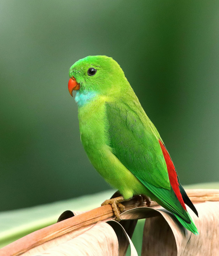

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for forest photos


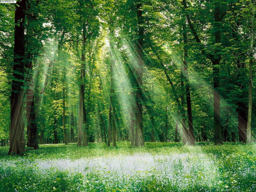

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for forest photo
Searching for forest sun photo
Searching for forest shade photo
Searching for bird photo
Searching for bird sun photo
Searching for bird shade photo


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

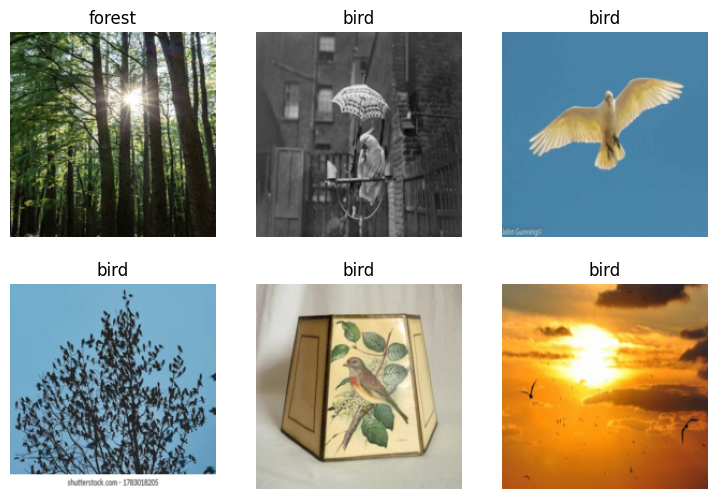

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.971144,0.758943,0.352941,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.093017,0.061047,0.029412,00:01
1,0.078653,0.038409,0.029412,00:00
2,0.052053,0.053454,0.029412,00:00


In [11]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9973


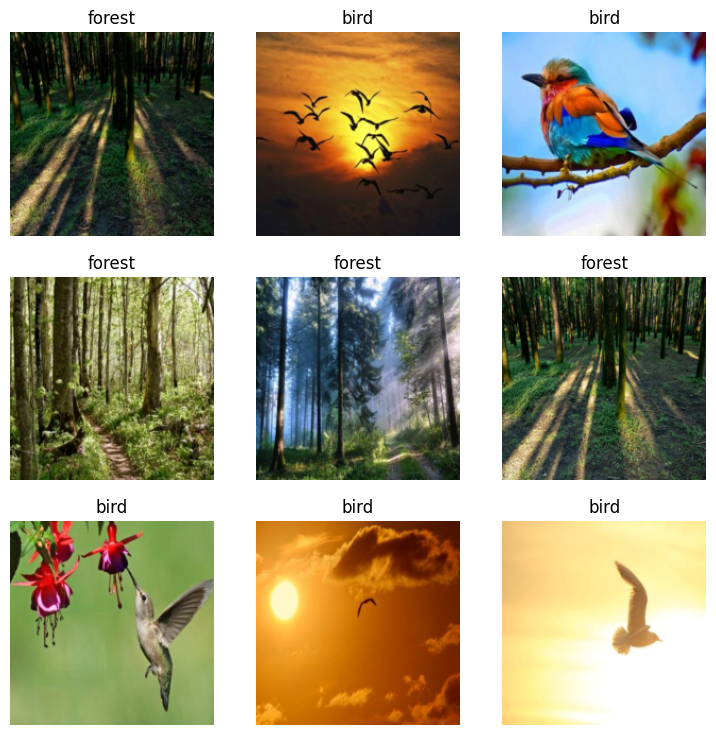

In [12]:
dls.show_batch()

In [13]:
from fastai.collab import*
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [14]:
dls.show_batch()

,userId,movieId,rating
0,111,296,4.5
1,607,2959,4.5
2,195,1036,1.0
3,587,2762,4.0
4,564,1732,5.0
5,665,500,2.0
6,292,736,4.5
7,212,589,3.0
8,665,380,3.0
9,452,593,5.0


In [15]:
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.468727,1.416131,00:00


epoch,train_loss,valid_loss,time
0,1.396199,1.362362,00:00
1,1.297821,1.201864,00:00
2,1.056718,0.900439,00:00
3,0.811178,0.728192,00:00
4,0.705448,0.675390,00:00
5,0.637440,0.654703,00:00
6,0.611662,0.644262,00:00
7,0.621601,0.641952,00:00
8,0.617740,0.640688,00:00
9,0.609083,0.640536,00:00
